<a href="https://colab.research.google.com/github/mlvlab/KCCV2024_ProMetaR_Tutorial/blob/main/KCCV2024_ProMetaR_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#KCCV2024_ProMetaR_Tutorial
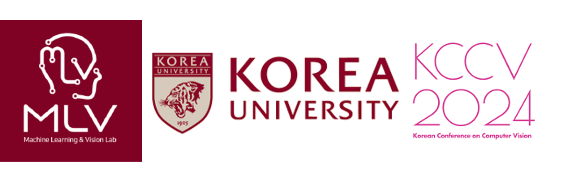

## Prompt Learning via Meta-Regularization
[[paper](https://arxiv.org/pdf/2404.00851)][[github](https://github.com/mlvlab/ProMetaR)]

Jinyoung Park, Juyeon Ko, Hyunwoo J. Kim

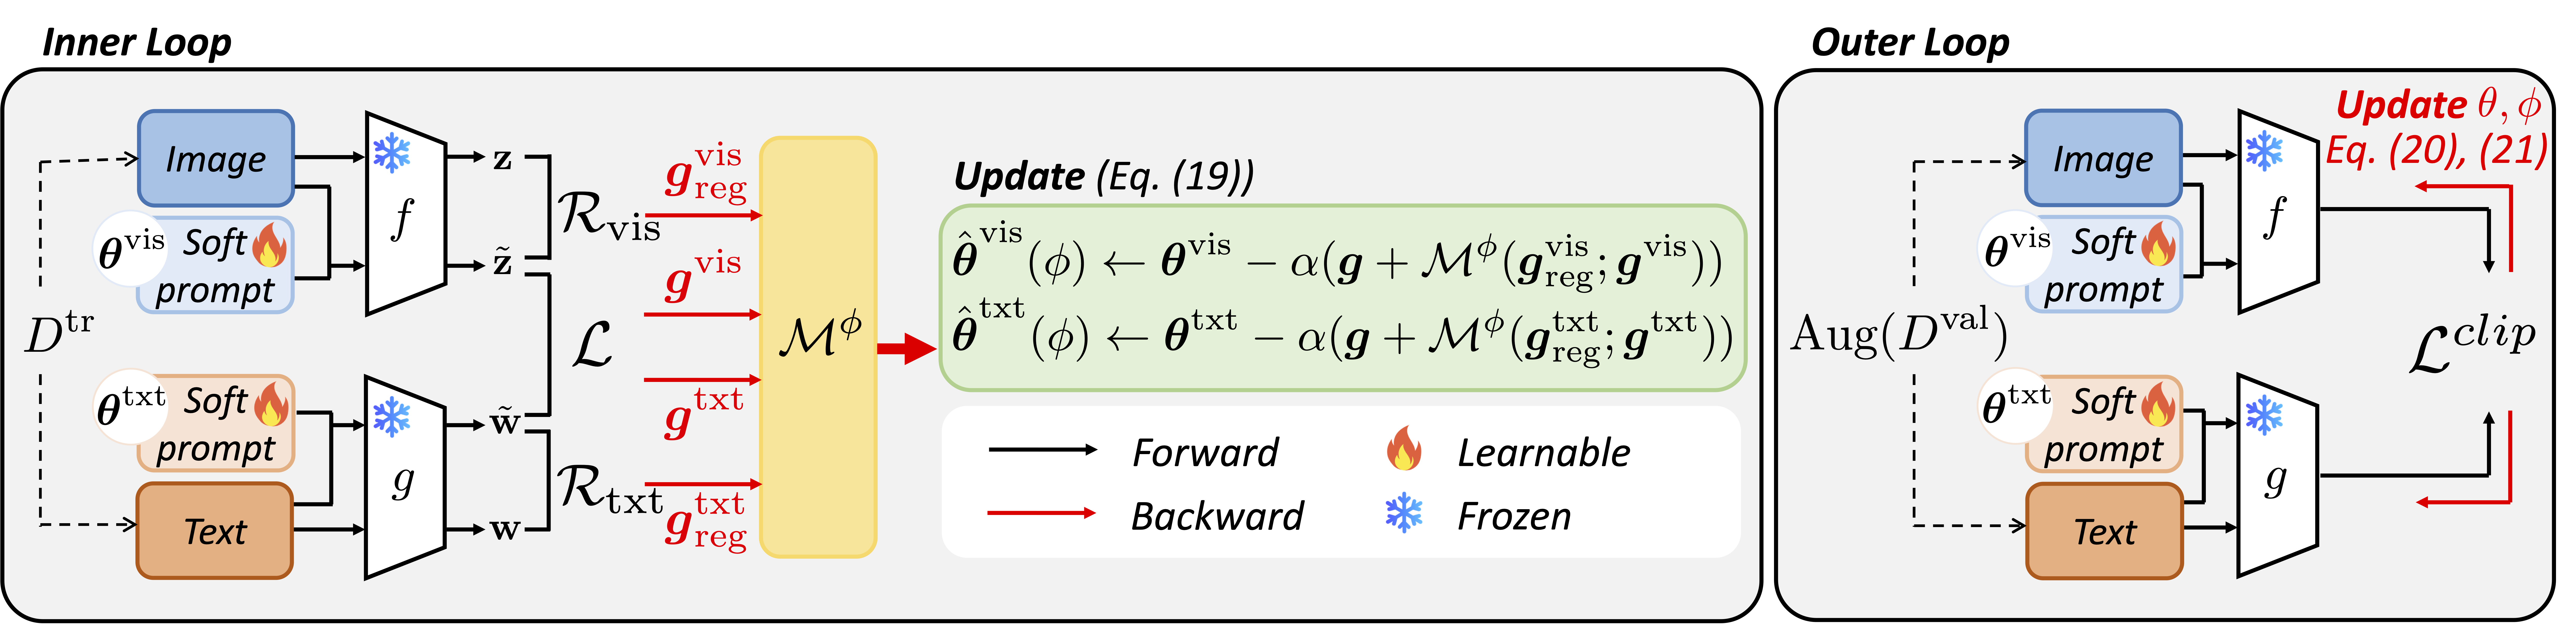

## 실습내용: CoOp, CoCoOp과 같은 기본적인 Prompt learning 방식 및 ProMetaR 구현

### Steps:
**[1] CLIP 이해하기**

**[2] CoOp 구현하기**

**[3] CoCoOp 구현하기**

**[4] ProMetaR 구현하기**

---
## 사전작업
### 1. github clone

In [ ]:
!git clone https://github.com/mlvlab/ProMetaR.git

fatal: destination path 'ProMetaR' already exists and is not an empty directory.


왼쪽 파일에 ProMetaR 폴더 생성

### 2. Requirements 설치

In [ ]:
%cd ProMetaR/

!git clone https://github.com/KaiyangZhou/Dassl.pytorch.git
%cd Dassl.pytorch/

# Install dependencies
!pip install -r requirements.txt
!cp -r dassl ../
# Install this library (no need to re-build if the source code is modified)
# !python setup.py develop
%cd ..

!pip install -r requirements.txt

/content/ProMetaR
fatal: destination path 'Dassl.pytorch' already exists and is not an empty directory.
/content/ProMetaR/Dassl.pytorch
/content/ProMetaR


Error 발생시 세션다시실행 클릭 후 다시 처음 부터 런타임 다시 실행



### 3. Data 불러오기
- EuroSAT
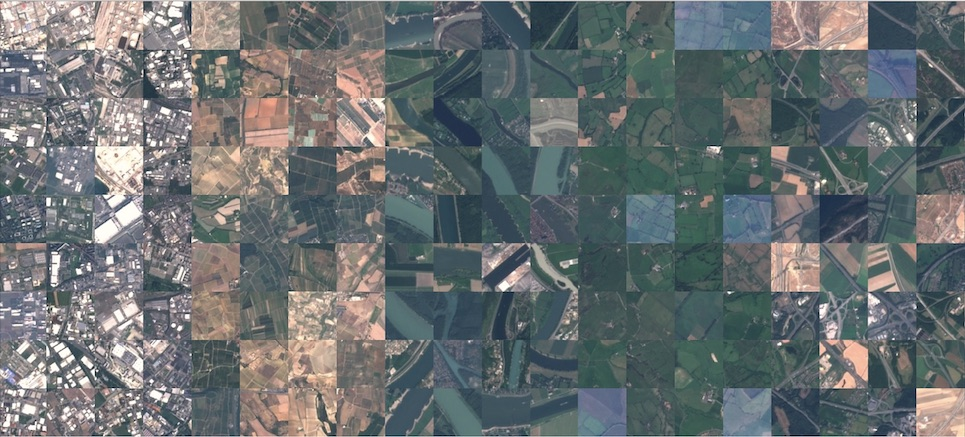

In [ ]:
%mkdir outputs
%mkdir data

%cd data
%mkdir eurosat
!wget http://madm.dfki.de/files/sentinel/EuroSAT.zip EuroSAT.zip

!unzip -o EuroSAT.zip -d eurosat/
%cd eurosat
!gdown 1Ip7yaCWFi0eaOFUGga0lUdVi_DDQth1o

%cd ../../


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: eurosat/2750/SeaLake/SeaLake_1817.jpg  
  inflating: eurosat/2750/SeaLake/SeaLake_2902.jpg  
  inflating: eurosat/2750/SeaLake/SeaLake_2570.jpg  
  inflating: eurosat/2750/SeaLake/SeaLake_1004.jpg  
  inflating: eurosat/2750/SeaLake/SeaLake_174.jpg  
  inflating: eurosat/2750/SeaLake/SeaLake_2111.jpg  
  inflating: eurosat/2750/SeaLake/SeaLake_2388.jpg  
  inflating: eurosat/2750/SeaLake/SeaLake_1948.jpg  
  inflating: eurosat/2750/SeaLake/SeaLake_838.jpg  
  inflating: eurosat/2750/SeaLake/SeaLake_2738.jpg  
  inflating: eurosat/2750/SeaLake/SeaLake_1999.jpg  
  inflating: eurosat/2750/SeaLake/SeaLake_2359.jpg  
  inflating: eurosat/2750/SeaLake/SeaLake_2660.jpg  
  inflating: eurosat/2750/SeaLake/SeaLake_1775.jpg  
  inflating: eurosat/2750/SeaLake/SeaLake_605.jpg  
  inflating: eurosat/2750/SeaLake/SeaLake_2201.jpg  
  inflating: eurosat/2750/SeaLake/SeaLake_264.jpg  
  inflating: eurosat/2750/SeaLake/SeaLake_1314.jpg  
  inflating: e

ProMetaR 폴더 안 data folder의 구성이 아래와 같아야함.

eurosat/2750

eurosat/split_fewshot

eurosat/split_zhou_EuroSAT.json

---

## [1] CLIP 이해하기
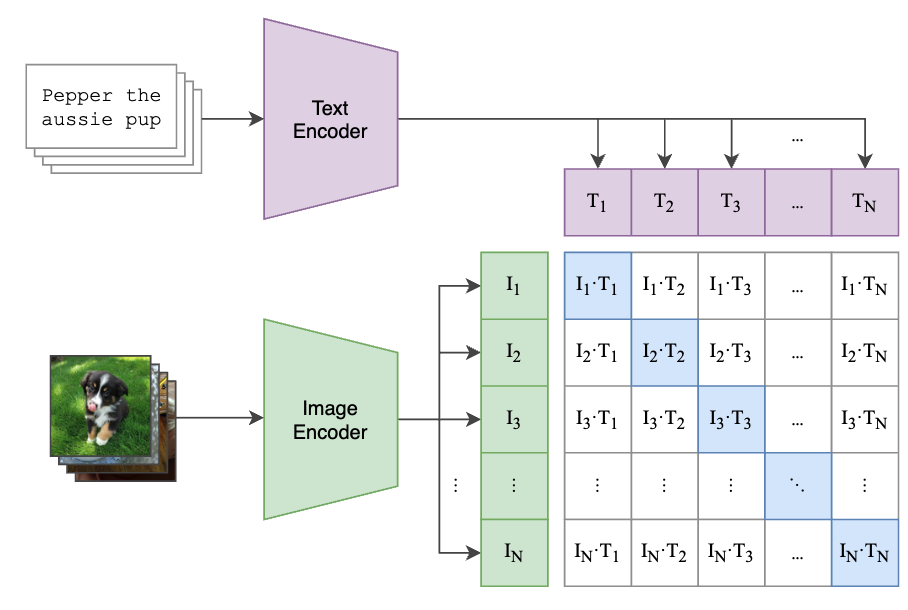


In [ ]:
import os.path as osp
from collections import OrderedDict
import math

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.cuda.amp import GradScaler, autocast

from dassl.engine import TRAINER_REGISTRY, TrainerX
from dassl.metrics import compute_accuracy
from dassl.utils import load_pretrained_weights, load_checkpoint
from dassl.optim import build_optimizer, build_lr_scheduler

from clip import clip
from clip.simple_tokenizer import SimpleTokenizer as _Tokenizer
import time

_tokenizer = _Tokenizer()


def load_clip_to_cpu(cfg): #CLIP 불러오기
    backbone_name = cfg.MODEL.BACKBONE.NAME
    url = clip._MODELS[backbone_name]
    model_path = clip._download(url)

    try:
        # loading JIT archive
        model = torch.jit.load(model_path, map_location="cpu").eval()
        state_dict = None

    except RuntimeError:
        state_dict = torch.load(model_path, map_location="cpu")

    if cfg.TRAINER.NAME == "":
      design_trainer = "CoOp"
    elif cfg.TRAINER.NAME == "ProMetaR":
      design_trainer = "CoCoOp"
    else:
      design_trainer = cfg.TRAINER.NAME
    design_details = {"trainer": design_trainer,
                      "vision_depth": 0,
                      "language_depth": 0, "vision_ctx": 0,
                      "language_ctx": 0}
    model = clip.build_model(state_dict or model.state_dict(), design_details)

    return model

In [ ]:
from dassl.config import get_cfg_default
cfg = get_cfg_default()
cfg.MODEL.BACKBONE.NAME = "ViT-B/16" # CLIP의 vision encoder backbone을 ViT로 설정.
clip_model = load_clip_to_cpu(cfg)
clip_model

100%|████████████████████████████████████████| 351M/351M [00:03<00:00, 106MiB/s]


CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

### Text Encoder Attention Mask 확인

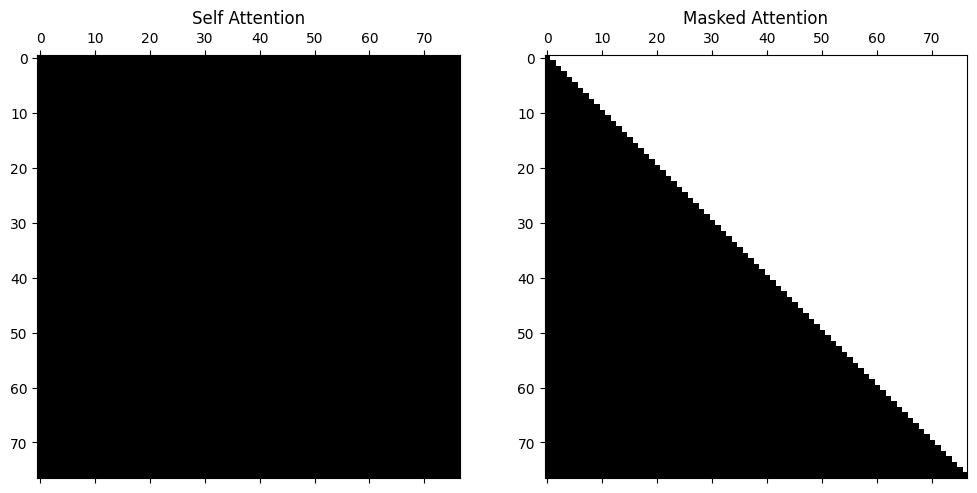

In [ ]:
from matplotlib import pyplot as plt
mask = clip_model.build_attention_mask()
self_attn_mask = torch.zeros_like(mask)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# 첫 번째 attention map
ax = axes[0]
cax = ax.matshow(self_attn_mask, cmap='gray')
ax.set_title('Self Attention') # Self-attention

# 두 번째 attention map
ax = axes[1]
cax = ax.matshow(mask, cmap='gray')
ax.set_title('Masked Attention') # Autoregressive한 attention mask

# 그래프 보여주기
plt.show()

###Text Encoder of CLIP

**Input**
- **prompts**: input prompts - 예) "A photo of a cat."
- **tokenized_prompts**: tokenized input prompts (해당 prompt의 최대 길이를 알기 위해 사용) - 예) [49283, 1523, 3612, 243, 0, ..., 0]

**Output**
- **x**: text representation of input prompts



In [ ]:
class TextEncoder(nn.Module):
    def __init__(self, clip_model): # 초기화 하는 함수
        super().__init__()
        self.transformer = clip_model.transformer
        self.positional_embedding = clip_model.positional_embedding
        self.ln_final = clip_model.ln_final
        self.text_projection = clip_model.text_projection
        self.dtype = clip_model.dtype

    def forward(self, prompts, tokenized_prompts): # 모델 호출
        x = prompts + self.positional_embedding.type(self.dtype)
        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD
        x = self.ln_final(x).type(self.dtype)

        # x.shape = [batch_size, n_ctx, transformer.width]
        # take features from the eot embedding (eot_token is the highest number in each sequence)
        x = x[torch.arange(x.shape[0]), tokenized_prompts.argmax(dim=-1)] @ self.text_projection

        return x

In [ ]:
classnames = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
classnames = [name.replace("_", " ") for name in classnames]
name_lens = [len(_tokenizer.encode(name)) for name in classnames]
prompts = ["A photo of " + name + "." for name in classnames]
tokenized_prompts = torch.cat([clip.tokenize(p) for p in prompts])
print("prompts: ", prompts[1])
print("tokenized_prompts: ", tokenized_prompts[1])

prompts:  A photo of Forest.
tokenized_prompts:  tensor([49406,   320,  1125,   539,  4167,   269, 49407,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0])


## [2] CoOp 구현하기
- **prompts**: input prompts
  $$ \left[\mathbf{v}_1,\mathbf{v}_2, \dots ,\mathbf{v}_M,\text{c}_i\right] $$
  - $\mathbf{v}_m$: learnable prompts
  - $\text{c}_i$: Class  예) Forest
- **ctx_init**: 정해진 포멧에 해당하는 텍스트 (e.g., "A photo of")를 tokenize한 후 tokenized embedding으로 initialization
- **random_init**: Normal distribution에서 샘플링 하여 Initialization

In [ ]:
class CoOpPromptLearner(nn.Module):
    def __init__(self, cfg, classnames, clip_model):
        super().__init__()
        n_cls = len(classnames)
        n_ctx = cfg.TRAINER.COOP.N_CTX
        ctx_init = cfg.TRAINER.COOP.CTX_INIT
        dtype = clip_model.dtype
        ctx_dim = clip_model.ln_final.weight.shape[0]
        clip_imsize = clip_model.visual.input_resolution
        cfg_imsize = cfg.INPUT.SIZE[0]
        assert cfg_imsize == clip_imsize, f"cfg_imsize ({cfg_imsize}) must equal to clip_imsize ({clip_imsize})"

        ### Learnable Prompts Initialization (Prompts 초기화) ###
        if ctx_init:
            # use given words to initialize context vectors
            ctx_init = ctx_init.replace("_", " ")
            n_ctx = len(ctx_init.split(" "))
            prompt = clip.tokenize(ctx_init)
            with torch.no_grad():
                embedding = clip_model.token_embedding(prompt).type(dtype)
            ctx_vectors = embedding[0, 1 : 1 + n_ctx, :]
            prompt_prefix = ctx_init

        else:
            # random initialization
            if cfg.TRAINER.COOP.CSC:
                print("Initializing class-specific contexts")
                ctx_vectors = torch.empty(n_cls, n_ctx, ctx_dim, dtype=dtype)
            else:
                print("Initializing a generic context")
                ctx_vectors = torch.empty(n_ctx, ctx_dim, dtype=dtype)
            nn.init.normal_(ctx_vectors, std=0.02)
            prompt_prefix = " ".join(["X"] * n_ctx)
        #######################################################

        print(f'Initial context: "{prompt_prefix}"')
        print(f"Number of context words (tokens): {n_ctx}")

        self.ctx = nn.Parameter(ctx_vectors)  # 위에 초기화한 prompts를 학습가능하게 Parameter로 감싸준다.

        ### Tokenize ###
        classnames = [name.replace("_", " ") for name in classnames]  # 예) "Forest"
        name_lens = [len(_tokenizer.encode(name)) for name in classnames]
        prompts = [prompt_prefix + " " + name + "." for name in classnames] # 예) "A photo of Forest."

        tokenized_prompts = torch.cat([clip.tokenize(p) for p in prompts]) # 예) [49406, 320, 1125, 539...]
        ################

        with torch.no_grad():
            embedding = clip_model.token_embedding(tokenized_prompts).type(dtype)
        # These token vectors will be saved when in save_model(),
        # but they should be ignored in load_model() as we want to use
        # those computed using the current class names
        self.register_buffer("token_prefix", embedding[:, :1, :])  # SOS (문장의 시작을 알려주는 토큰)
        self.register_buffer("token_suffix", embedding[:, 1 + n_ctx :, :])  # CLS, EOS (문장의 끝을 알려주는 토큰)

        self.n_cls = n_cls
        self.n_ctx = n_ctx
        self.tokenized_prompts = tokenized_prompts  # torch.Tensor
        self.name_lens = name_lens

    def construct_prompts(self, ctx, prefix, suffix, label=None):
        # dim0 is either batch_size (during training) or n_cls (during testing)
        # ctx: context tokens, with shape of (dim0, n_ctx, ctx_dim)
        # prefix: the sos token, with shape of (n_cls, 1, ctx_dim)
        # suffix: remaining tokens, with shape of (n_cls, *, ctx_dim)

        if label is not None:
            prefix = prefix[label]
            suffix = suffix[label]

        prompts = torch.cat(
            [
                prefix,  # (dim0, 1, dim)
                ctx,  # (dim0, n_ctx, dim)
                suffix,  # (dim0, *, dim)
            ],
            dim=1,
        )

        return prompts

    def forward(self):
        ctx = self.ctx
        if ctx.dim() == 2:
            ctx = ctx.unsqueeze(0).expand(self.n_cls, -1, -1)

        prefix = self.token_prefix
        suffix = self.token_suffix
        prompts = self.construct_prompts(ctx, prefix, suffix) #[시작토큰, Input prompts,끝 토큰]

        return prompts

### Prompt initialization 방식

- **ctx_init**: 정해진 텍스트 (e.g., "A photo of")를 tokenize한 후 tokenized embedding으로 initialization

In [ ]:
ctx_init = "A photo of"
ctx_init = ctx_init.replace("_", " ")
n_ctx = len(ctx_init.split(" "))
print(ctx_init)
prompt = clip.tokenize(ctx_init)
print(prompt)
with torch.no_grad():
    embedding = clip_model.token_embedding(prompt)
ctx_vectors = embedding[0, 1 : 1 + n_ctx, :]
prompt_prefix = ctx_init

A photo of
tensor([[49406,   320,  1125,   539, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]])


- **random_init**: Normal distribution에서 샘플링 하여 Initialization

In [ ]:
prompt_prefix = " ".join(["X"] * 2)
print(prompt_prefix)

X X


## [3] CoCoOp 구현하기

CoCoOp은 CoOp과 다르게 learnable prompts를 input image를 기반으로 만든다.

**중요 변수**
- self.meta_net : meta network $\boldsymbol{h_\theta}$ (MLP 로 정의)
- bias: $ \boldsymbol{\pi} = h_{\theta}\left(\mathbf{x} \right)$
- ctx: $\mathbf{v}_m$
- ctx_shifted: $\mathbf{v}_m\left(\mathbf{x}\right) = \mathbf{v}_m + \boldsymbol{\pi}  $
- prompts: $\mathbf{t}_i\left(\mathbf{x} \right) = \left[\mathbf{v}\left(\mathbf{x}\right)_1,\mathbf{v}\left(\mathbf{x}\right)_2, \dots, \mathbf{v}\left(\mathbf{x}\right)_M, \text{c}_i\right]$

In [ ]:
class CoCoOpPromptLearner(nn.Module):
    def __init__(self, cfg, classnames, clip_model):
        super().__init__()
        n_cls = len(classnames)
        n_ctx = cfg.TRAINER.COCOOP.N_CTX
        ctx_init = cfg.TRAINER.COCOOP.CTX_INIT
        dtype = clip_model.dtype
        ctx_dim = clip_model.ln_final.weight.shape[0]
        vis_dim = clip_model.visual.output_dim
        clip_imsize = clip_model.visual.input_resolution
        cfg_imsize = cfg.INPUT.SIZE[0]
        assert cfg_imsize == clip_imsize, f"cfg_imsize ({cfg_imsize}) must equal to clip_imsize ({clip_imsize})"

        if ctx_init:
            # use given words to initialize context vectors
            ctx_init = ctx_init.replace("_", " ")
            n_ctx = len(ctx_init.split(" "))
            prompt = clip.tokenize(ctx_init)
            with torch.no_grad():
                embedding = clip_model.token_embedding(prompt).type(dtype)
            ctx_vectors = embedding[0, 1: 1 + n_ctx, :]
            prompt_prefix = ctx_init
        else:
            # random initialization
            ctx_vectors = torch.empty(n_ctx, ctx_dim, dtype=dtype)
            nn.init.normal_(ctx_vectors, std=0.02)
            prompt_prefix = " ".join(["X"] * n_ctx)

        print(f'Initial context: "{prompt_prefix}"')
        print(f"Number of context words (tokens): {n_ctx}")

        self.ctx = nn.Parameter(ctx_vectors)  # 위에 초기화한 prompts를 학습가능하게 Parameter로 감싸준다.

        ##### Define Meta Net #####
        self.meta_net = nn.Sequential(OrderedDict([
            ("linear1", nn.Linear(vis_dim, vis_dim // 16)),
            ("relu", nn.ReLU(inplace=True)),
            ("linear2", nn.Linear(vis_dim // 16, ctx_dim))
        ]))
        ############################

        if cfg.TRAINER.COCOOP.PREC == "fp16":
            self.meta_net.half()

        ### Tokenize ###
        classnames = [name.replace("_", " ") for name in classnames]  # 예) "Forest"
        name_lens = [len(_tokenizer.encode(name)) for name in classnames]
        prompts = [prompt_prefix + " " + name + "." for name in classnames] # 예) "A photo of Forest."

        tokenized_prompts = torch.cat([clip.tokenize(p) for p in prompts]) # 예) [49406, 320, 1125, 539...]
        ################

        with torch.no_grad():
            embedding = clip_model.token_embedding(tokenized_prompts).type(dtype)

        # These token vectors will be saved when in save_model(),
        # but they should be ignored in load_model() as we want to use
        # those computed using the current class names
        self.register_buffer("token_prefix", embedding[:, :1, :])  # SOS
        self.register_buffer("token_suffix", embedding[:, 1 + n_ctx:, :])  # CLS, EOS

        self.n_cls = n_cls
        self.n_ctx = n_ctx
        self.tokenized_prompts = tokenized_prompts  # torch.Tensor
        self.name_lens = name_lens

    def construct_prompts(self, ctx, prefix, suffix, label=None):
        # dim0 is either batch_size (during training) or n_cls (during testing)
        # ctx: context tokens, with shape of (dim0, n_ctx, ctx_dim)
        # prefix: the sos token, with shape of (n_cls, 1, ctx_dim)
        # suffix: remaining tokens, with shape of (n_cls, *, ctx_dim)

        if label is not None:
            prefix = prefix[label]
            suffix = suffix[label]

        prompts = torch.cat(
            [
                prefix,  # (dim0, 1, dim)
                ctx,  # (dim0, n_ctx, dim)
                suffix,  # (dim0, *, dim)
            ],
            dim=1,
        )

        return prompts

    def forward(self, im_features):
        prefix = self.token_prefix
        suffix = self.token_suffix
        ctx = self.ctx  # (n_ctx, ctx_dim)

        ##### Add meta token to context tokens #####
        bias = self.meta_net(im_features)  # (batch, ctx_dim)
        bias = bias.unsqueeze(1)  # (batch, 1, ctx_dim)
        ctx = ctx.unsqueeze(0)  # (1, n_ctx, ctx_dim)
        ctx_shifted = ctx + bias  # (batch, n_ctx, ctx_dim)
        ############################################

        # Use instance-conditioned context tokens for all classes
        prompts = []
        for ctx_shifted_i in ctx_shifted:
            ctx_i = ctx_shifted_i.unsqueeze(0).expand(self.n_cls, -1, -1)
            pts_i = self.construct_prompts(ctx_i, prefix, suffix)  # (n_cls, n_tkn, ctx_dim)
            prompts.append(pts_i)
        prompts = torch.stack(prompts)

        return prompts


### Logit 계산하기
- image_features : Image representation $\mathbf{f}$
- text_features : Text representation $g\left(\mathbf{t}_i\right)$
- Logit:
$p\left(y=i | \mathbf{x} \right) = \frac{\exp \left(\cos\left(g\left(\mathbf{t}_i\right),\mathbf{f} \right)/\tau \right)}{\sum_{j=1}^K \exp \left(\cos\left(g\left(\mathbf{t}_j\right),\mathbf{f} \right)/\tau \right)} $

**참고: Cosine similarity**

Cosine similarity = $\cos(x,y)$ = $\frac{x \cdot y}{\left\lVert x \right\rVert \left\lVert y \right\rVert}$


CoOp과 CoCoOp의 Logit계산하는 방식은 똑같지만 구현상으로 CoCoOp은 for문을 사용하는 부분이 나타난다. 다른이유가 무엇일까?

In [ ]:
class CoOpCustomCLIP(nn.Module):
    def __init__(self, cfg, classnames, clip_model):
        super().__init__()
        self.prompt_learner = CoOpPromptLearner(cfg, classnames, clip_model)
        self.tokenized_prompts = self.prompt_learner.tokenized_prompts
        self.image_encoder = clip_model.visual
        self.text_encoder = TextEncoder(clip_model)
        self.logit_scale = clip_model.logit_scale
        self.dtype = clip_model.dtype

    def forward(self, image):
        image_features = self.image_encoder(image.type(self.dtype))

        prompts = self.prompt_learner()
        tokenized_prompts = self.tokenized_prompts
        text_features = self.text_encoder(prompts, tokenized_prompts)

        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        logit_scale = self.logit_scale.exp()
        logits = logit_scale * image_features @ text_features.t()

        return logits

In [ ]:
class CoCoOpCustomCLIP(nn.Module):
    def __init__(self, cfg, classnames, clip_model):
        super().__init__()
        self.prompt_learner = CoCoOpPromptLearner(cfg, classnames, clip_model)
        self.tokenized_prompts = self.prompt_learner.tokenized_prompts
        self.image_encoder = clip_model.visual
        self.text_encoder = TextEncoder(clip_model)
        self.logit_scale = clip_model.logit_scale
        self.dtype = clip_model.dtype

    def forward(self, image, label=None):
        tokenized_prompts = self.tokenized_prompts
        logit_scale = self.logit_scale.exp()

        image_features = self.image_encoder(image.type(self.dtype))
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)

        prompts = self.prompt_learner(image_features)

        logits = []
        for pts_i, imf_i in zip(prompts, image_features):
            text_features = self.text_encoder(pts_i, tokenized_prompts)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)
            l_i = logit_scale * imf_i @ text_features.t()
            logits.append(l_i)
        logits = torch.stack(logits)

        if self.prompt_learner.training:
            return F.cross_entropy(logits, label)

        return logits

### 학습 진행하기

In [ ]:
from tqdm import tqdm
import datetime


@TRAINER_REGISTRY.register(force=True)
class CoOp(TrainerX):
    """Context Optimization (CoOp).

    Learning to Prompt for Vision-Language Models
    https://arxiv.org/abs/2109.01134
    """

    def check_cfg(self, cfg):
        assert cfg.TRAINER.COOP.PREC in ["fp16", "fp32", "amp"]

    def build_model(self):
        cfg = self.cfg
        classnames = self.dm.dataset.classnames

        print(f"Loading CLIP (backbone: {cfg.MODEL.BACKBONE.NAME})")
        clip_model = load_clip_to_cpu(cfg)

        if cfg.TRAINER.COOP.PREC == "fp32" or cfg.TRAINER.COOP.PREC == "amp":
            # CLIP's default precision is fp16
            clip_model.float()

        print("Building custom CLIP")
        self.model = CoOpCustomCLIP(cfg, classnames, clip_model)

        print("Turning off gradients in both the image and the text encoder")
        for name, param in self.model.named_parameters():
            if "prompt_learner" not in name:
                param.requires_grad_(False)

        if cfg.MODEL.INIT_WEIGHTS:
            load_pretrained_weights(self.model.prompt_learner, cfg.MODEL.INIT_WEIGHTS)

        self.model.to(self.device)
        # NOTE: only give prompt_learner to the optimizer
        self.optim = build_optimizer(self.model.prompt_learner, cfg.OPTIM)
        self.sched = build_lr_scheduler(self.optim, cfg.OPTIM)
        self.register_model("prompt_learner", self.model.prompt_learner, self.optim, self.sched)

        self.scaler = GradScaler() if cfg.TRAINER.COOP.PREC == "amp" else None

        # Note that multi-gpu training could be slow because CLIP's size is
        # big, which slows down the copy operation in DataParallel
        device_count = torch.cuda.device_count()
        if device_count > 1:
            print(f"Multiple GPUs detected (n_gpus={device_count}), use all of them!")
            self.model = nn.DataParallel(self.model)

    def before_train(self):
        directory = self.cfg.OUTPUT_DIR
        if self.cfg.RESUME:
            directory = self.cfg.RESUME
        self.start_epoch = self.resume_model_if_exist(directory)

        # Remember the starting time (for computing the elapsed time)
        self.time_start = time.time()

    def forward_backward(self, batch):
        image, label = self.parse_batch_train(batch)

        prec = self.cfg.TRAINER.COOP.PREC
        output = self.model(image)      # Input image 모델 통과
        loss = F.cross_entropy(output, label)  # Loss 선언
        self.model_backward_and_update(loss)  # Backward 및 모델 parameter 업데이트

        loss_summary = {
            "loss": loss.item(),
            "acc": compute_accuracy(output, label)[0].item(),
        }

        if (self.batch_idx + 1) == self.num_batches:
            self.update_lr()

        return loss_summary

    def parse_batch_train(self, batch):
        input = batch["img"]
        label = batch["label"]
        input = input.to(self.device)
        label = label.to(self.device)
        return input, label

    def load_model(self, directory, epoch=None):
        if not directory:
            print("Note that load_model() is skipped as no pretrained model is given")
            return

        names = self.get_model_names()

        # By default, the best model is loaded
        model_file = "model-best.pth.tar"

        if epoch is not None:
            model_file = "model.pth.tar-" + str(epoch)

        for name in names:
            model_path = osp.join(directory, name, model_file)

            if not osp.exists(model_path):
                raise FileNotFoundError('Model not found at "{}"'.format(model_path))

            checkpoint = load_checkpoint(model_path)
            state_dict = checkpoint["state_dict"]
            epoch = checkpoint["epoch"]

            # Ignore fixed token vectors
            if "token_prefix" in state_dict:
                del state_dict["token_prefix"]

            if "token_suffix" in state_dict:
                del state_dict["token_suffix"]

            print("Loading weights to {} " 'from "{}" (epoch = {})'.format(name, model_path, epoch))
            # set strict=False
            self._models[name].load_state_dict(state_dict, strict=False)

    def after_train(self):
      print("Finish training")

      do_test = not self.cfg.TEST.NO_TEST
      if do_test:
          if self.cfg.TEST.FINAL_MODEL == "best_val":
              print("Deploy the model with the best val performance")
              self.load_model(self.output_dir)
          else:
              print("Deploy the last-epoch model")
          acc = self.test()

      # Show elapsed time
      elapsed = round(time.time() - self.time_start)
      elapsed = str(datetime.timedelta(seconds=elapsed))
      print(f"Elapsed: {elapsed}")

      # Close writer
      self.close_writer()
      return acc

    def train(self):
        """Generic training loops."""
        self.before_train()
        for self.epoch in range(self.start_epoch, self.max_epoch):
            self.before_epoch()
            self.run_epoch()
            self.after_epoch()
        acc = self.after_train()
        return acc

In [ ]:
@TRAINER_REGISTRY.register(force=True)
class CoCoOp(TrainerX):
    def check_cfg(self, cfg):
        assert cfg.TRAINER.COCOOP.PREC in ["fp16", "fp32", "amp"]

    def build_model(self):
        cfg = self.cfg
        classnames = self.dm.dataset.classnames
        print(f"Loading CLIP (backbone: {cfg.MODEL.BACKBONE.NAME})")
        clip_model = load_clip_to_cpu(cfg)

        if cfg.TRAINER.COCOOP.PREC == "fp32" or cfg.TRAINER.COCOOP.PREC == "amp":
            # CLIP's default precision is fp16
            clip_model.float()

        print("Building custom CLIP")
        self.model = CoCoOpCustomCLIP(cfg, classnames, clip_model)

        print("Turning off gradients in both the image and the text encoder")
        name_to_update = "prompt_learner"

        for name, param in self.model.named_parameters():
            if name_to_update not in name:
                param.requires_grad_(False)

        # Double check
        enabled = set()
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                enabled.add(name)
        print(f"Parameters to be updated: {enabled}")

        if cfg.MODEL.INIT_WEIGHTS:
            load_pretrained_weights(self.model.prompt_learner, cfg.MODEL.INIT_WEIGHTS)

        self.model.to(self.device)
        # NOTE: only give prompt_learner to the optimizer
        self.optim = build_optimizer(self.model.prompt_learner, cfg.OPTIM)
        self.sched = build_lr_scheduler(self.optim, cfg.OPTIM)
        self.register_model("prompt_learner", self.model.prompt_learner, self.optim, self.sched)

        self.scaler = GradScaler() if cfg.TRAINER.COCOOP.PREC == "amp" else None

        # Note that multi-gpu training could be slow because CLIP's size is
        # big, which slows down the copy operation in DataParallel
        device_count = torch.cuda.device_count()
        if device_count > 1:
            print(f"Multiple GPUs detected (n_gpus={device_count}), use all of them!")
            self.model = nn.DataParallel(self.model)

    def before_train(self):
        directory = self.cfg.OUTPUT_DIR
        if self.cfg.RESUME:
            directory = self.cfg.RESUME
        self.start_epoch = self.resume_model_if_exist(directory)

        # Remember the starting time (for computing the elapsed time)
        self.time_start = time.time()


    def forward_backward(self, batch):
        image, label = self.parse_batch_train(batch)

        model = self.model
        optim = self.optim
        scaler = self.scaler

        prec = self.cfg.TRAINER.COCOOP.PREC
        loss = model(image, label) # Input image 모델 통과
        optim.zero_grad()
        loss.backward() # Backward (역전파)
        optim.step() # 모델 parameter update

        loss_summary = {"loss": loss.item()}

        if (self.batch_idx + 1) == self.num_batches:
            self.update_lr()

        return loss_summary

    def parse_batch_train(self, batch):
        input = batch["img"]
        label = batch["label"]
        input = input.to(self.device)
        label = label.to(self.device)
        return input, label

    def load_model(self, directory, epoch=None):
        if not directory:
            print("Note that load_model() is skipped as no pretrained model is given")
            return

        names = self.get_model_names()

        # By default, the best model is loaded
        model_file = "model-best.pth.tar"

        if epoch is not None:
            model_file = "model.pth.tar-" + str(epoch)

        for name in names:
            model_path = osp.join(directory, name, model_file)

            if not osp.exists(model_path):
                raise FileNotFoundError('Model not found at "{}"'.format(model_path))

            checkpoint = load_checkpoint(model_path)
            state_dict = checkpoint["state_dict"]
            epoch = checkpoint["epoch"]

            # Ignore fixed token vectors
            if "token_prefix" in state_dict:
                del state_dict["token_prefix"]

            if "token_suffix" in state_dict:
                del state_dict["token_suffix"]

            print("Loading weights to {} " 'from "{}" (epoch = {})'.format(name, model_path, epoch))
            # set strict=False
            self._models[name].load_state_dict(state_dict, strict=False)

    def after_train(self):
      print("Finish training")

      do_test = not self.cfg.TEST.NO_TEST
      if do_test:
          if self.cfg.TEST.FINAL_MODEL == "best_val":
              print("Deploy the model with the best val performance")
              self.load_model(self.output_dir)
          else:
              print("Deploy the last-epoch model")
          acc = self.test()

      # Show elapsed time
      elapsed = round(time.time() - self.time_start)
      elapsed = str(datetime.timedelta(seconds=elapsed))
      print(f"Elapsed: {elapsed}")

      # Close writer
      self.close_writer()
      return acc

    def train(self):
        """Generic training loops."""
        self.before_train()
        for self.epoch in range(self.start_epoch, self.max_epoch):
            self.before_epoch()
            self.run_epoch()
            self.after_epoch()
        acc = self.after_train()
        return acc

In [ ]:
import argparse
import torch

from dassl.utils import setup_logger, set_random_seed, collect_env_info
from dassl.config import get_cfg_default
from dassl.engine import build_trainer

# custom
import datasets.oxford_pets
import datasets.oxford_flowers
import datasets.fgvc_aircraft
import datasets.dtd
import datasets.eurosat
import datasets.stanford_cars
import datasets.food101
import datasets.sun397
import datasets.caltech101
import datasets.ucf101
import datasets.imagenet

import datasets.imagenet_sketch
import datasets.imagenetv2
import datasets.imagenet_a
import datasets.imagenet_r


def print_args(args, cfg):
    print("***************")
    print("** Arguments **")
    print("***************")
    optkeys = list(args.__dict__.keys())
    optkeys.sort()
    for key in optkeys:
        print("{}: {}".format(key, args.__dict__[key]))
    print("************")
    print("** Config **")
    print("************")
    print(cfg)


def reset_cfg(cfg, args):
    if args.root:
        cfg.DATASET.ROOT = args.root

    if args.output_dir:
        cfg.OUTPUT_DIR = args.output_dir

    if args.seed:
        cfg.SEED = args.seed

    if args.trainer:
        cfg.TRAINER.NAME = args.trainer

    cfg.DATASET.NUM_SHOTS = 16
    cfg.DATASET.SUBSAMPLE_CLASSES = args.subsample_classes
    cfg.DATALOADER.TRAIN_X.BATCH_SIZE = args.train_batch_size
    cfg.OPTIM.MAX_EPOCH = args.epoch



def extend_cfg(cfg):
    """
    Add new config variables.

    E.g.
        from yacs.config import CfgNode as CN
        cfg.TRAINER.MY_MODEL = CN()
        cfg.TRAINER.MY_MODEL.PARAM_A = 1.
        cfg.TRAINER.MY_MODEL.PARAM_B = 0.5
        cfg.TRAINER.MY_MODEL.PARAM_C = False
    """
    from yacs.config import CfgNode as CN

    cfg.TRAINER.COOP = CN()
    cfg.TRAINER.COOP.N_CTX = 16  # number of context vectors
    cfg.TRAINER.COOP.CSC = False  # class-specific context
    cfg.TRAINER.COOP.CTX_INIT = ""  # initialization words
    cfg.TRAINER.COOP.PREC = "fp16"  # fp16, fp32, amp
    cfg.TRAINER.COOP.CLASS_TOKEN_POSITION = "end"  # 'middle' or 'end' or 'front'

    cfg.TRAINER.COCOOP = CN()
    cfg.TRAINER.COCOOP.N_CTX = 4  # number of context vectors
    cfg.TRAINER.COCOOP.CTX_INIT = "a photo of a"  # initialization words
    cfg.TRAINER.COCOOP.PREC = "fp16"  # fp16, fp32, amp

    # # Config for independent Vision Language prompting (independent-vlp)
    # cfg.TRAINER.IVLP = CN()
    # cfg.TRAINER.IVLP.N_CTX_VISION = 2  # number of context vectors at the vision branch
    # cfg.TRAINER.IVLP.N_CTX_TEXT = 2  # number of context vectors at the language branch
    # cfg.TRAINER.IVLP.CTX_INIT = "a photo of a"  # initialization words (only for language prompts)
    # cfg.TRAINER.IVLP.PREC = "fp16"  # fp16, fp32, amp
    # # If both variables below are set to 0, 0, will the config will degenerate to COOP model
    # cfg.TRAINER.IVLP.PROMPT_DEPTH_VISION = 9  # Max 12, minimum 0, for 0 it will act as shallow IVLP prompting (J=1)
    # cfg.TRAINER.IVLP.PROMPT_DEPTH_TEXT = 9  # Max 12, minimum 0, for 0 it will act as shallow IVLP prompting(J=1)
    # cfg.DATASET.SUBSAMPLE_CLASSES = "all"  # all, base or new

    cfg.TRAINER.PROMETAR = CN()
    cfg.TRAINER.PROMETAR.N_CTX_VISION = 4  # number of context vectors at the vision branch
    cfg.TRAINER.PROMETAR.N_CTX_TEXT = 4  # number of context vectors at the language branch
    cfg.TRAINER.PROMETAR.CTX_INIT = "a photo of a"  # initialization words
    cfg.TRAINER.PROMETAR.PREC = "fp16"  # fp16, fp32, amp
    cfg.TRAINER.PROMETAR.PROMPT_DEPTH_VISION = 9  # Max 12, minimum 0, for 0 it will be using shallow IVLP prompting (J=1)
    cfg.TRAINER.PROMETAR.PROMPT_DEPTH_TEXT = 9  # Max 12, minimum 0, for 0 it will be using shallow IVLP prompting (J=1)
    cfg.DATASET.SUBSAMPLE_CLASSES = "all"  # all, base or new


    cfg.TRAINER.PROMETAR.ADAPT_LR = 0.0005
    cfg.TRAINER.PROMETAR.LR_RATIO = 0.0005

    cfg.TRAINER.PROMETAR.FAST_ADAPTATION = False
    cfg.TRAINER.PROMETAR.MIXUP_ALPHA = 0.5
    cfg.TRAINER.PROMETAR.MIXUP_BETA = 0.5

    cfg.TRAINER.PROMETAR.DIM_RATE=8

    cfg.OPTIM_VNET = CN()
    cfg.OPTIM_VNET.NAME = "adam"
    cfg.OPTIM_VNET.LR = 0.0003
    cfg.OPTIM_VNET.WEIGHT_DECAY = 5e-4
    cfg.OPTIM_VNET.MOMENTUM = 0.9
    cfg.OPTIM_VNET.SGD_DAMPNING = 0
    cfg.OPTIM_VNET.SGD_NESTEROV = False
    cfg.OPTIM_VNET.RMSPROP_ALPHA = 0.99
    # The following also apply to other
    # adaptive optimizers like adamw
    cfg.OPTIM_VNET.ADAM_BETA1 = 0.9
    cfg.OPTIM_VNET.ADAM_BETA2 = 0.999
    # STAGED_LR allows different layers to have
    # different lr, e.g. pre-trained base layers
    # can be assigned a smaller lr than the new
    # classification layer
    cfg.OPTIM_VNET.STAGED_LR = False
    cfg.OPTIM_VNET.NEW_LAYERS = ()
    cfg.OPTIM_VNET.BASE_LR_MULT = 0.1
    # Learning rate scheduler
    cfg.OPTIM_VNET.LR_SCHEDULER = "single_step"
    # -1 or 0 means the stepsize is equal to max_epoch
    cfg.OPTIM_VNET.STEPSIZE = (-1, )
    cfg.OPTIM_VNET.GAMMA = 0.1
    cfg.OPTIM_VNET.MAX_EPOCH = 10
    # Set WARMUP_EPOCH larger than 0 to activate warmup training
    cfg.OPTIM_VNET.WARMUP_EPOCH = -1
    # Either linear or constant
    cfg.OPTIM_VNET.WARMUP_TYPE = "linear"
    # Constant learning rate when type=constant
    cfg.OPTIM_VNET.WARMUP_CONS_LR = 1e-5
    # Minimum learning rate when type=linear
    cfg.OPTIM_VNET.WARMUP_MIN_LR = 1e-5
    # Recount epoch for the next scheduler (last_epoch=-1)
    # Otherwise last_epoch=warmup_epoch
    cfg.OPTIM_VNET.WARMUP_RECOUNT = True

def setup_cfg(args):
    cfg = get_cfg_default()
    extend_cfg(cfg)

    # 1. From the dataset config file
    if args.dataset_config_file:
        cfg.merge_from_file(args.dataset_config_file)

    # 2. From the method config file
    if args.config_file:
        cfg.merge_from_file(args.config_file)

    # 3. From input arguments
    reset_cfg(cfg, args)

    cfg.freeze()

    return cfg


def main(args):
    cfg = setup_cfg(args)
    if cfg.SEED >= 0:
        print("Setting fixed seed: {}".format(cfg.SEED))
        set_random_seed(cfg.SEED)

    if torch.cuda.is_available() and cfg.USE_CUDA:
        torch.backends.cudnn.benchmark = True

    print_args(args, cfg)
    print("Collecting env info ...")
    print("** System info **\n{}\n".format(collect_env_info()))

    trainer = build_trainer(cfg)

    if args.eval_only:
        trainer.load_model(args.model_dir, epoch=args.load_epoch)
        acc = trainer.test()
        return acc

    acc = trainer.train()
    return acc

parser = argparse.ArgumentParser()
parser.add_argument("--root", type=str, default="data/", help="path to dataset")
parser.add_argument("--output-dir", type=str, default="outputs/cocoop3", help="output directory")
parser.add_argument(
    "--seed", type=int, default=1, help="only positive value enables a fixed seed"
)
parser.add_argument(
    "--config-file", type=str, default="configs/trainers/ProMetaR/vit_b16_c2_ep10_batch4_4+4ctx.yaml", help="path to config file"
)
parser.add_argument(
    "--dataset-config-file",
    type=str,
    default="configs/datasets/eurosat.yaml",
    help="path to config file for dataset setup",
)
parser.add_argument("--trainer", type=str, default="CoCoOp", help="name of trainer")
parser.add_argument("--eval-only", action="store_true", help="evaluation only")
parser.add_argument(
    "--model-dir",
    type=str,
    default="",
    help="load model from this directory for eval-only mode",
)
parser.add_argument("--train-batch-size", type=int, default=4)
parser.add_argument("--epoch", type=int, default=10)
parser.add_argument("--subsample-classes", type=str, default="base")
parser.add_argument(
    "--load-epoch", type=int, default=0, help="load model weights at this epoch for evaluation"
)
args = parser.parse_args([])

### CoOp Base Class에 대한 결과 보기
- Base class는 학습 때 봤던 class를 지칭
- 반대로 New class는 학습 때 보지 않았던 class를 지칭

In [ ]:
args.trainer = "CoOp"
args.train_batch_size = 4
args.epoch = 100
args.output_dir = "outputs/coop"

# Base Classes Train split에 대해 학습 및 Test split에 대한 Acc
args.subsample_classes = "base"
args.eval_only = False
coop_base_acc = main(args)

Setting fixed seed: 1
***************
** Arguments **
***************
config_file: configs/trainers/ProMetaR/vit_b16_c2_ep10_batch4_4+4ctx.yaml
dataset_config_file: configs/datasets/eurosat.yaml
epoch: 100
eval_only: False
load_epoch: 0
model_dir: 
output_dir: outputs/coop
root: data/
seed: 1
subsample_classes: base
train_batch_size: 4
trainer: CoOp
************
** Config **
************
DATALOADER:
  K_TRANSFORMS: 1
  NUM_WORKERS: 8
  RETURN_IMG0: False
  TEST:
    BATCH_SIZE: 100
    SAMPLER: SequentialSampler
  TRAIN_U:
    BATCH_SIZE: 32
    N_DOMAIN: 0
    N_INS: 16
    SAME_AS_X: True
    SAMPLER: RandomSampler
  TRAIN_X:
    BATCH_SIZE: 4
    N_DOMAIN: 0
    N_INS: 16
    SAMPLER: RandomSampler
DATASET:
  ALL_AS_UNLABELED: False
  CIFAR_C_LEVEL: 1
  CIFAR_C_TYPE: 
  NAME: EuroSAT
  NUM_LABELED: -1
  NUM_SHOTS: 16
  ROOT: data/
  SOURCE_DOMAINS: ()
  STL10_FOLD: -1
  SUBSAMPLE_CLASSES: base
  TARGET_DOMAINS: ()
  VAL_PERCENT: 0.1
INPUT:
  COLORJITTER_B: 0.4
  COLORJITTER_C: 0.4
 

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Building custom CLIP
Initializing a generic context
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16
Turning off gradients in both the image and the text encoder
Loading evaluator: Classification
No checkpoint found, train from scratch


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch [1/100] batch [20/20] time 0.031 (0.248) data 0.000 (0.037) loss 1.0020 (1.1951) acc 75.0000 (60.0000) lr 2.5000e-03 eta 0:08:10
epoch [2/100] batch [20/20] time 0.091 (0.086) data 0.000 (0.019) loss 0.4148 (1.0582) acc 100.0000 (55.0000) lr 2.4994e-03 eta 0:02:49
epoch [3/100] batch [20/20] time 0.057 (0.108) data 0.000 (0.046) loss 0.6074 (0.5703) acc 75.0000 (80.0000) lr 2.4975e-03 eta 0:03:29
epoch [4/100] batch [20/20] time 0.030 (0.092) data 0.000 (0.030) loss 0.2260 (0.7246) acc 100.0000 (71.2500) lr 2.4945e-03 eta 0:02:56
epoch [5/100] batch [20/20] time 0.029 (0.061) data 0.000 (0.019) loss 1.4834 (0.5166) acc 75.0000 (81.2500) lr 2.4901e-03 eta 0:01:55
epoch [6/100] batch [20/20] time 0.036 (0.061) data 0.000 (0.022) loss 0.4045 (0.5312) acc 75.0000 (81.2500) lr 2.4846e-03 eta 0:01:54
epoch [7/100] batch [20/20] time 0.031 (0.058) data 0.000 (0.016) loss 0.2070 (0.4746) acc 100.0000 (85.0000) lr 2.4779e-03 eta 0:01:48
epoch [8/100] batch [20/20] time 0.035 (0.060) data 

100%|██████████| 42/42 [00:19<00:00,  2.18it/s]

=> result
* total: 4,200
* correct: 3,839
* accuracy: 91.4%
* error: 8.6%
* macro_f1: 91.5%
Elapsed: 0:03:18


### CoOp New Class에 대한 결과 보기

In [ ]:
# New Classes 에 대한 Acc
args.model_dir = "outputs/coop"
args.output_dir = "outputs/coop/new_classes"
args.subsample_classes = "new"
args.load_epoch = 100
args.eval_only = True
coop_novel_acc = main(args)

Setting fixed seed: 1
***************
** Arguments **
***************
config_file: configs/trainers/ProMetaR/vit_b16_c2_ep10_batch4_4+4ctx.yaml
dataset_config_file: configs/datasets/eurosat.yaml
epoch: 100
eval_only: True
load_epoch: 100
model_dir: outputs/coop
output_dir: outputs/coop/new_classes
root: data/
seed: 1
subsample_classes: new
train_batch_size: 4
trainer: CoOp
************
** Config **
************
DATALOADER:
  K_TRANSFORMS: 1
  NUM_WORKERS: 8
  RETURN_IMG0: False
  TEST:
    BATCH_SIZE: 100
    SAMPLER: SequentialSampler
  TRAIN_U:
    BATCH_SIZE: 32
    N_DOMAIN: 0
    N_INS: 16
    SAME_AS_X: True
    SAMPLER: RandomSampler
  TRAIN_X:
    BATCH_SIZE: 4
    N_DOMAIN: 0
    N_INS: 16
    SAMPLER: RandomSampler
DATASET:
  ALL_AS_UNLABELED: False
  CIFAR_C_LEVEL: 1
  CIFAR_C_TYPE: 
  NAME: EuroSAT
  NUM_LABELED: -1
  NUM_SHOTS: 16
  ROOT: data/
  SOURCE_DOMAINS: ()
  STL10_FOLD: -1
  SUBSAMPLE_CLASSES: new
  TARGET_DOMAINS: ()
  VAL_PERCENT: 0.1
INPUT:
  COLORJITTER_B: 0.4

  0%|          | 0/39 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 39/39 [00:19<00:00,  3.00it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 39/39 [00:20<00:00,  1.94it/s]

=> result
* total: 3,900
* correct: 2,007
* accuracy: 51.5%
* error: 48.5%
* macro_f1: 45.6%


### CoCoOp Base Class에 대한 결과 보기

In [ ]:
args.trainer = "CoCoOp"
args.train_batch_size = 1
args.epoch = 10
args.output_dir = "outputs/cocoop"

# Base Classes Train split에 대해 학습 및 Test split에 대한 Acc
args.subsample_classes = "base"
args.eval_only = False
cocoop_base_acc = main(args)

Setting fixed seed: 1
***************
** Arguments **
***************
config_file: configs/trainers/ProMetaR/vit_b16_c2_ep10_batch4_4+4ctx.yaml
dataset_config_file: configs/datasets/eurosat.yaml
epoch: 10
eval_only: False
load_epoch: 100
model_dir: outputs/coop
output_dir: outputs/cocoop
root: data/
seed: 1
subsample_classes: base
train_batch_size: 1
trainer: CoCoOp
************
** Config **
************
DATALOADER:
  K_TRANSFORMS: 1
  NUM_WORKERS: 8
  RETURN_IMG0: False
  TEST:
    BATCH_SIZE: 100
    SAMPLER: SequentialSampler
  TRAIN_U:
    BATCH_SIZE: 32
    N_DOMAIN: 0
    N_INS: 16
    SAME_AS_X: True
    SAMPLER: RandomSampler
  TRAIN_X:
    BATCH_SIZE: 1
    N_DOMAIN: 0
    N_INS: 16
    SAMPLER: RandomSampler
DATASET:
  ALL_AS_UNLABELED: False
  CIFAR_C_LEVEL: 1
  CIFAR_C_TYPE: 
  NAME: EuroSAT
  NUM_LABELED: -1
  NUM_SHOTS: 16
  ROOT: data/
  SOURCE_DOMAINS: ()
  STL10_FOLD: -1
  SUBSAMPLE_CLASSES: base
  TARGET_DOMAINS: ()
  VAL_PERCENT: 0.1
INPUT:
  COLORJITTER_B: 0.4
  COL

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Building custom CLIP
Initial context: "a photo of a"
Number of context words (tokens): 4
Turning off gradients in both the image and the text encoder
Parameters to be updated: {'prompt_learner.meta_net.linear1.bias', 'prompt_learner.meta_net.linear2.bias', 'prompt_learner.meta_net.linear1.weight', 'prompt_learner.ctx', 'prompt_learner.meta_net.linear2.weight'}
Loading evaluator: Classification
No checkpoint found, train from scratch


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch [1/10] batch [20/80] time 0.058 (0.148) data 0.000 (0.045) loss 1.3369 (1.8436) lr 1.0000e-05 eta 0:01:55
epoch [1/10] batch [40/80] time 0.063 (0.114) data 0.000 (0.023) loss 0.1398 (1.4474) lr 1.0000e-05 eta 0:01:26
epoch [1/10] batch [60/80] time 0.159 (0.113) data 0.000 (0.015) loss 0.5103 (1.3589) lr 1.0000e-05 eta 0:01:23


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch [1/10] batch [80/80] time 0.110 (0.117) data 0.000 (0.012) loss 1.3467 (1.1790) lr 2.5000e-03 eta 0:01:24
epoch [2/10] batch [20/80] time 0.101 (0.118) data 0.000 (0.041) loss 0.8491 (1.1615) lr 2.5000e-03 eta 0:01:22
epoch [2/10] batch [40/80] time 0.036 (0.078) data 0.000 (0.021) loss 2.0664 (1.1380) lr 2.5000e-03 eta 0:00:53
epoch [2/10] batch [60/80] time 0.037 (0.065) data 0.001 (0.014) loss 1.2686 (1.0337) lr 2.5000e-03 eta 0:00:43
epoch [2/10] batch [80/80] time 0.046 (0.059) data 0.000 (0.011) loss 0.0544 (0.9567) lr 2.4388e-03 eta 0:00:37
epoch [3/10] batch [20/80] time 0.039 (0.063) data 0.000 (0.021) loss 0.1367 (0.7422) lr 2.4388e-03 eta 0:00:39
epoch [3/10] batch [40/80] time 0.038 (0.051) data 0.000 (0.011) loss 1.2715 (0.5894) lr 2.4388e-03 eta 0:00:30
epoch [3/10] batch [60/80] time 0.039 (0.047) data 0.001 (0.007) loss 0.2791 (0.6541) lr 2.4388e-03 eta 0:00:27
epoch [3/10] batch [80/80] time 0.032 (0.043) data 0.000 (0.006) loss 0.7373 (0.7264) lr 2.2613e-03 eta 

100%|██████████| 42/42 [01:06<00:00,  1.58s/it]

=> result
* total: 4,200
* correct: 3,431
* accuracy: 81.7%
* error: 18.3%
* macro_f1: 81.5%
Elapsed: 0:01:55


### CoCoOp New Class에 대한 결과 보기

In [ ]:
# New Classes 에 대한 Acc
args.model_dir = "outputs/cocoop"
args.output_dir = "outputs/cocoop/new_classes"
args.subsample_classes = "new"
args.load_epoch = 10
args.eval_only = True
cocoop_novel_acc = main(args)

Setting fixed seed: 1
***************
** Arguments **
***************
config_file: configs/trainers/ProMetaR/vit_b16_c2_ep10_batch4_4+4ctx.yaml
dataset_config_file: configs/datasets/eurosat.yaml
epoch: 10
eval_only: True
load_epoch: 10
model_dir: outputs/cocoop
output_dir: outputs/cocoop/new_classes
root: data/
seed: 1
subsample_classes: new
train_batch_size: 1
trainer: CoCoOp
************
** Config **
************
DATALOADER:
  K_TRANSFORMS: 1
  NUM_WORKERS: 8
  RETURN_IMG0: False
  TEST:
    BATCH_SIZE: 100
    SAMPLER: SequentialSampler
  TRAIN_U:
    BATCH_SIZE: 32
    N_DOMAIN: 0
    N_INS: 16
    SAME_AS_X: True
    SAMPLER: RandomSampler
  TRAIN_X:
    BATCH_SIZE: 1
    N_DOMAIN: 0
    N_INS: 16
    SAMPLER: RandomSampler
DATASET:
  ALL_AS_UNLABELED: False
  CIFAR_C_LEVEL: 1
  CIFAR_C_TYPE: 
  NAME: EuroSAT
  NUM_LABELED: -1
  NUM_SHOTS: 16
  ROOT: data/
  SOURCE_DOMAINS: ()
  STL10_FOLD: -1
  SUBSAMPLE_CLASSES: new
  TARGET_DOMAINS: ()
  VAL_PERCENT: 0.1
INPUT:
  COLORJITTER_B:

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Building custom CLIP
Initial context: "a photo of a"
Number of context words (tokens): 4
Turning off gradients in both the image and the text encoder
Parameters to be updated: {'prompt_learner.meta_net.linear1.bias', 'prompt_learner.meta_net.linear2.bias', 'prompt_learner.meta_net.linear1.weight', 'prompt_learner.ctx', 'prompt_learner.meta_net.linear2.weight'}
Loading evaluator: Classification
Loading weights to prompt_learner from "outputs/cocoop/prompt_learner/model.pth.tar-10" (epoch = 10)
Evaluate on the *test* set


  0%|          | 0/39 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 39/39 [01:09<00:00,  1.54s/it]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 39/39 [01:09<00:00,  1.79s/it]

=> result
* total: 3,900
* correct: 1,849
* accuracy: 47.4%
* error: 52.6%
* macro_f1: 43.4%


### CoOp, CoCoOp 비교하기

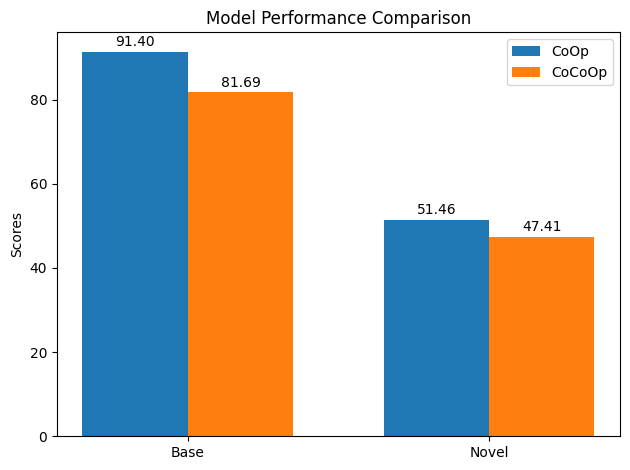

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 메트릭 데이터
metrics = ['Base', 'Novel']

coop_acc_list = [coop_base_acc, coop_novel_acc]
cocoop_acc_list = [cocoop_base_acc, cocoop_novel_acc]


# 막대 너비
bar_width = 0.35

# X축 위치 설정
index = np.arange(len(metrics))

# bar plot 생성
fig, ax = plt.subplots()

bar1 = ax.bar(index, coop_acc_list, bar_width, label='CoOp')
bar2 = ax.bar(index + bar_width, cocoop_acc_list, bar_width, label='CoCoOp')

# 제목과 레이블 설정
ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(metrics)
ax.legend()

# 막대에 값 표시
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 2),  # 2 points vertical offset
                    textcoords='offset points',
                    ha='center', va='bottom')

add_value_labels(bar1)
add_value_labels(bar2)

# 그래프 출력
plt.tight_layout()
plt.show()


## ProMetaR 구현하기

In [ ]:
import copy
import os.path as osp
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.cuda.amp import GradScaler, autocast

from dassl.engine import TRAINER_REGISTRY, TrainerX
from dassl.utils import load_pretrained_weights, load_checkpoint
from dassl.optim import build_optimizer, build_lr_scheduler
from clip import clip
from clip.simple_tokenizer import SimpleTokenizer as _Tokenizer

import learn2learn as l2l
from meta_learning import MAML
from torch.autograd import grad

IMAGENET_TEMPLATES = [
    "a photo of a {}.",
    "a bad photo of a {}.",
    "a photo of many {}.",
    "a sculpture of a {}.",
    "a photo of the hard to see {}.",
    "a low resolution photo of the {}.",
    "a rendering of a {}.",
    "graffiti of a {}.",
    "a bad photo of the {}.",
    "a cropped photo of the {}.",
    "a tattoo of a {}.",
    "the embroidered {}.",
    "a photo of a hard to see {}.",
    "a bright photo of a {}.",
    "a photo of a clean {}.",
    "a photo of a dirty {}.",
    "a dark photo of the {}.",
    "a drawing of a {}.",
    "a photo of my {}.",
    "the plastic {}.",
    "a photo of the cool {}.",
    "a close-up photo of a {}.",
    "a black and white photo of the {}.",
    "a painting of the {}.",
    "a painting of a {}.",
    "a pixelated photo of the {}.",
    "a sculpture of the {}.",
    "a bright photo of the {}.",
    "a cropped photo of a {}.",
    "a plastic {}.",
    "a photo of the dirty {}.",
    "a jpeg corrupted photo of a {}.",
    "a blurry photo of the {}.",
    "a photo of the {}.",
    "a good photo of the {}.",
    "a rendering of the {}.",
    "a {} in a video game.",
    "a photo of one {}.",
    "a doodle of a {}.",
    "a close-up photo of the {}.",
    "the origami {}.",
    "the {} in a video game.",
    "a sketch of a {}.",
    "a doodle of the {}.",
    "a origami {}.",
    "a low resolution photo of a {}.",
    "the toy {}.",
    "a rendition of the {}.",
    "a photo of the clean {}.",
    "a photo of a large {}.",
    "a rendition of a {}.",
    "a photo of a nice {}.",
    "a photo of a weird {}.",
    "a blurry photo of a {}.",
    "a cartoon {}.",
    "art of a {}.",
    "a sketch of the {}.",
    "a embroidered {}.",
    "a pixelated photo of a {}.",
    "itap of the {}.",
]

_tokenizer = _Tokenizer()


def load_clip_to_cpu(cfg, zero_shot_model=False):
    backbone_name = cfg.MODEL.BACKBONE.NAME
    url = clip._MODELS[backbone_name]
    model_path = clip._download(url)

    try:
        # loading JIT archive
        model = torch.jit.load(model_path, map_location="cpu").eval()
        state_dict = None

    except RuntimeError:
        state_dict = torch.load(model_path, map_location="cpu")
    if not zero_shot_model:
        design_details = {"trainer": 'IVLP',
                          "vision_depth": cfg.TRAINER.PROMETAR.PROMPT_DEPTH_VISION,
                          "language_depth": cfg.TRAINER.PROMETAR.PROMPT_DEPTH_TEXT,
                          "vision_ctx": cfg.TRAINER.PROMETAR.N_CTX_VISION,
                          "language_ctx": cfg.TRAINER.PROMETAR.N_CTX_TEXT}
        model = clip.build_model(state_dict or model.state_dict(), design_details)
    else:
        # Return original CLIP model for generating frozen VL features
        design_details = {"trainer": 'IVLP',
                          "vision_depth": 0,
                          "language_depth": 0, "vision_ctx": 0,
                          "language_ctx": 0}
        model = clip.build_model(state_dict or model.state_dict(), design_details)
        return model
    return model



### Gradient update
- Backward 했을시 우리가 얻게 되는 Gradient를 바꿔주기 위해서 필요한 함수
- grad_func을 통해 gradient를 업데이트한다..

In [ ]:
def gradient_update(model, loss1, loss2, loss3, grad_func=None):
    diff_params = [p for p in model.parameters() if p.requires_grad]

    grad_params1 = grad(loss1,
                        diff_params,
                        retain_graph=True,
                        create_graph=True,
                        allow_unused=True) #loss 1에 대한 gradient 구하기
    grad_params2 = grad(loss2,
                        diff_params,
                        retain_graph=True,
                        create_graph=True,
                        allow_unused=True) #loss 2에 대한 gradient 구하기
    grad_params3 = grad(loss3,
                        diff_params,
                        retain_graph=True,
                        create_graph=True,
                        allow_unused=True) #loss 3에 대한 gradient 구하기

    gradients = []
    grad_counter = 0
    # Handles gradients for non-differentiable parameters
    for name, param in model.named_parameters():
        if param.requires_grad:
            gradient1 = grad_params1[grad_counter]
            gradient2 = grad_params2[grad_counter]
            gradient3 = grad_params3[grad_counter]
            if grad_func:
                if gradient2 == None:
                    gradient = grad_func(gradient1.type(grad_func.dtype), gradient2, gradient3.type(grad_func.dtype), name)
                elif gradient3 == None:
                    gradient = grad_func(gradient1.type(grad_func.dtype), gradient2.type(grad_func.dtype), gradient3, name)
                else:
                    raise NotImplemented
            grad_counter += 1
        else:
            gradient = None
        gradients.append(gradient)

    if gradients is not None:
        params = list(model.parameters())
        if not len(gradients) == len(list(params)):
            msg = 'WARNING:maml_update(): Parameters and gradients have different length. ('
            msg += str(len(params)) + ' vs ' + str(len(gradients)) + ')'
            print(msg)
        for p, g in zip(params, gradients):
            if g is not None:
                p.grad = g.type(p.dtype)

    else:
        print("Gradients are not updated!")

    return model



### VNet
- Gradient modulate 해주는 함수.

$$\mathbf{g} \rightarrow \mathbf{g} + {M}^{\phi}\left(\mathbf{g}_{\text{reg}} ; \mathbf{g}\right)$$

$${M}^{\phi}\left(\mathbf{g}_{\text{reg}} ; \mathbf{g}\right) = \sigma \left(\mathbf{m}^{\phi} \right)\odot \mathbf{g}_{\text{reg}}$$

In [ ]:
## Original ###
class VNet(nn.Module):
    def __init__(self, cfg, clip_model):
        super().__init__()
        self.dtype = clip_model.dtype
        vision_ctx_dim = clip_model.visual.conv1.weight.size(0)*cfg.TRAINER.PROMETAR.N_CTX_VISION
        text_ctx_dim = clip_model.ln_final.weight.shape[0]*cfg.TRAINER.PROMETAR.N_CTX_TEXT

        self.linear_vision_gamma = nn.ModuleList([nn.Sequential(nn.Linear(vision_ctx_dim*2, vision_ctx_dim//cfg.TRAINER.PROMETAR.DIM_RATE, bias=False),nn.Linear(vision_ctx_dim//cfg.TRAINER.PROMETAR.DIM_RATE, vision_ctx_dim//cfg.TRAINER.PROMETAR.DIM_RATE, bias=False)).type(self.dtype) for i in range(cfg.TRAINER.PROMETAR.PROMPT_DEPTH_VISION)])
        self.linear_text_gamma = nn.ModuleList([nn.Sequential(nn.Linear(text_ctx_dim*2, text_ctx_dim//cfg.TRAINER.PROMETAR.DIM_RATE, bias=False),nn.Linear(text_ctx_dim//cfg.TRAINER.PROMETAR.DIM_RATE, text_ctx_dim//cfg.TRAINER.PROMETAR.DIM_RATE, bias=False)).type(self.dtype) for i in range(cfg.TRAINER.PROMETAR.PROMPT_DEPTH_TEXT)])


    def forward(self, gradients1, gradients2, gradients3, param_name):
        if "image_encoder" in param_name:
            if param_name == "image_encoder.VPT":
                linear_gamma = self.linear_vision_gamma[0]
            else:
                l_idx = int(param_name.split("image_encoder.transformer.resblocks.")[1].split(".VPT_shallow")[0])
                linear_gamma = self.linear_vision_gamma[l_idx]

        elif "text_encoder" in param_name or (param_name == "prompt_learner.ctx"):
            if param_name == "prompt_learner.ctx":
                linear_gamma = self.linear_text_gamma[0]
            else:
                l_idx = int(param_name.split("text_encoder.transformer.resblocks.")[1].split(".VPT_shallow")[0])
                linear_gamma = self.linear_text_gamma[l_idx]
        else:
            raise NotImplemented

        d_1, d_2 = gradients1.size()
        changed_gradients1, changed_gradients2, changed_gradients3 = None, None, None
        #### Gradient update ####
        if gradients2 == None:
            input_gradients = torch.cat((gradients1, gradients3), 0)
            gamma_t = torch.sigmoid(linear_gamma(input_gradients.reshape(1,-1))).repeat_interleave(8,-1).reshape(d_1, d_2)
            changed_gradients = gamma_t*gradients3
            changed_gradients = gradients1 + changed_gradients

        elif gradients3 == None:
            input_gradients = torch.cat((gradients1, gradients2), 0)
            gamma_t = torch.sigmoid(linear_gamma(input_gradients.reshape(1,-1))).repeat_interleave(8,-1).reshape(d_1, d_2)
            changed_gradients = gamma_t*gradients2
            changed_gradients = gradients1 + changed_gradients
        else:
            raise NotImplemented
        #########################

        return changed_gradients



In [ ]:
class TextEncoder(nn.Module):
    def __init__(self, clip_model):
        super().__init__()
        self.transformer = clip_model.transformer
        self.positional_embedding = clip_model.positional_embedding
        self.ln_final = clip_model.ln_final
        self.text_projection = clip_model.text_projection
        self.dtype = clip_model.dtype

    def forward(self, prompts, tokenized_prompts):
        x = prompts + self.positional_embedding.type(self.dtype)
        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD
        x = self.ln_final(x).type(self.dtype)

        # x.shape = [batch_size, n_ctx, transformer.width]
        # take features from the eot embedding (eot_token is the highest number in each sequence)
        x = x[torch.arange(x.shape[0]), tokenized_prompts.argmax(dim=-1)] @ self.text_projection

        return x


class VLPromptLearner(nn.Module):
    def __init__(self, cfg, classnames, clip_model):
        super().__init__()
        n_cls = len(classnames)
        # Make sure Language depth >= 1
        assert cfg.TRAINER.PROMETAR.PROMPT_DEPTH_TEXT >= 1, "In Independent VL prompting, Language prompt depth should be >=1" \
                                                        "\nPlease use VPT trainer if you want to learn only vision " \
                                                        "branch"
        n_ctx = cfg.TRAINER.PROMETAR.N_CTX_TEXT
        ctx_init = cfg.TRAINER.PROMETAR.CTX_INIT
        dtype = clip_model.dtype
        ctx_dim = clip_model.ln_final.weight.shape[0]
        clip_imsize = clip_model.visual.input_resolution
        cfg_imsize = cfg.INPUT.SIZE[0]
        assert cfg_imsize == clip_imsize, f"cfg_imsize ({cfg_imsize}) must equal to clip_imsize ({clip_imsize})"

        if ctx_init and n_ctx <= 4:
            # use given words to initialize context vectors
            ctx_init = ctx_init.replace("_", " ")
            n_ctx = n_ctx
            prompt = clip.tokenize(ctx_init)
            with torch.no_grad():
                embedding = clip_model.token_embedding(prompt).type(dtype)
            ctx_vectors = embedding[0, 1: 1 + n_ctx, :]
            prompt_prefix = ctx_init
        else:
            # random initialization
            ctx_vectors = torch.empty(n_ctx, ctx_dim, dtype=dtype)
            nn.init.normal_(ctx_vectors, std=0.02)
            prompt_prefix = " ".join(["X"] * n_ctx)
        print(f"Independent V-L design")
        print(f'Initial text context: "{prompt_prefix}"')
        print(f"Number of context words (tokens) for Language prompting: {n_ctx}")
        print(f"Number of context words (tokens) for Vision prompting: {cfg.TRAINER.PROMETAR.N_CTX_VISION}")
        self.ctx = nn.Parameter(ctx_vectors)

        classnames = [name.replace("_", " ") for name in classnames]
        name_lens = [len(_tokenizer.encode(name)) for name in classnames]
        prompts = [prompt_prefix + " " + name + "." for name in classnames]

        tokenized_prompts = torch.cat([clip.tokenize(p) for p in prompts])  # (n_cls, n_tkn)
        # Also create frozen CLIP
        clip_model_temp = load_clip_to_cpu(cfg, True).float().cuda()
        clip_model_temp_image = load_clip_to_cpu(cfg, True)
        with torch.no_grad():
            embedding = clip_model.token_embedding(tokenized_prompts).type(dtype)
            self.ZS_image_encoder = clip_model_temp_image.visual
            # Now pre-compute the frozen VL embeddings
            all_teacher_features = []
            # Using multiple text templates to ensure textual diversity during training
            for single_template in IMAGENET_TEMPLATES:
                x = [single_template.replace("{}", name) for name in classnames]
                x_tokenized = torch.cat([clip.tokenize(p) for p in x])
                text_features = clip_model_temp.encode_text(x_tokenized.cuda())
                all_teacher_features.append(text_features.unsqueeze(1))

        self.fixed_embeddings = torch.cat(all_teacher_features, dim=1).mean(dim=1)
        # These token vectors will be saved when in save_model(),
        # but they should be ignored in load_model() as we want to use
        # those computed using the current class names
        self.register_buffer("token_prefix", embedding[:, :1, :])  # SOS
        self.register_buffer("token_suffix", embedding[:, 1 + n_ctx:, :])  # CLS, EOS

        self.n_cls = n_cls
        self.n_ctx = n_ctx
        self.tokenized_prompts = tokenized_prompts  # torch.Tensor
        self.name_lens = name_lens

    def construct_prompts(self, ctx, prefix, suffix, label=None):
        # dim0 is either batch_size (during training) or n_cls (during testing)
        # ctx: context tokens, with shape of (dim0, n_ctx, ctx_dim)
        # prefix: the sos token, with shape of (n_cls, 1, ctx_dim)
        # suffix: remaining tokens, with shape of (n_cls, *, ctx_dim)

        if label is not None:
            prefix = prefix[label]
            suffix = suffix[label]

        prompts = torch.cat(
            [
                prefix,  # (dim0, 1, dim)
                ctx,  # (dim0, n_ctx, dim)
                suffix,  # (dim0, *, dim)
            ],
            dim=1,
        )

        return prompts

    def forward(self):
        ctx = self.ctx
        if ctx.dim() == 2:
            ctx = ctx.unsqueeze(0).expand(self.n_cls, -1, -1)

        prefix = self.token_prefix
        suffix = self.token_suffix
        prompts = self.construct_prompts(ctx, prefix, suffix)

        return prompts

### Task augmentation with manifold mix

- Output representation 및 label을 mixup
$$\hat{\mathbf{h}}_{\text{val}}^{(i)} = \rho {\mathbf{h}}_{\text{val}}^{(i)} + (1-\rho) {\mathbf{h}}_{\text{tr}}^{(i)},$$
$$\hat{y}_{\text{val}}^{(i)} = \rho y_{\text{val}}^{(i)} + (1-\rho) y_{\text{tr}}^{(i)},$$

In [ ]:
class ProMetaRCustomCLIP(nn.Module):
    def __init__(self, cfg, classnames, clip_model):
        super().__init__()
        self.prompt_learner = VLPromptLearner(cfg, classnames, clip_model)
        self.tokenized_prompts = self.prompt_learner.tokenized_prompts
        self.image_encoder = clip_model.visual
        self.text_encoder = TextEncoder(clip_model)
        self.logit_scale = clip_model.logit_scale
        self.dtype = clip_model.dtype
        self.total_epochs = cfg.OPTIM.MAX_EPOCH
        self.n_cls = len(classnames)


    def forward(self, image, label=None, image_sup=None, label_sup=None, mix_ids=None, lam=None, mixup=False):
        tokenized_prompts = self.tokenized_prompts
        logit_scale = self.logit_scale.exp()

        prompts = self.prompt_learner()
        # Compute the prompted image and text features
        text_features = self.text_encoder(prompts, tokenized_prompts)
        image_features = self.image_encoder(image.type(self.dtype))
        if self.prompt_learner.training and mixup:
            b_size = image.size(0)
            image_features_sup = self.image_encoder(image_sup.type(self.dtype))
            image_features = lam.view(b_size, 1)*image_features + (1-lam).view(b_size,1)*image_features_sup[mix_ids]
            image_features = image_features.type(self.dtype)
            label_b = label_sup[mix_ids]

        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        # Compute the prompted logits
        logits = logit_scale * image_features @ text_features.t()
        if self.prompt_learner.training:
            # Now calculate the frozen pre-trained features
            fixed_embeddings = self.prompt_learner.fixed_embeddings  # precomputed pre-trained frozen textual features
            fixed_embeddings = fixed_embeddings / fixed_embeddings.norm(dim=-1, keepdim=True)
            with torch.no_grad():
                zero_shot_features = self.prompt_learner.ZS_image_encoder(image.type(self.dtype))
                zero_shot_features = zero_shot_features / zero_shot_features.norm(dim=-1, keepdim=True)
                # Compute pre-trained frozen visual features
                zero_shot_logits = logit_scale * zero_shot_features.cuda() @ fixed_embeddings.half().cuda().t()

            if mixup:
                ce_loss = (lam*F.cross_entropy(logits, label, reduce=False)+(1-lam)*F.cross_entropy(logits, label_b, reduce=False)).mean()
            else:
                ce_loss = F.cross_entropy(logits, label)

            return ce_loss, text_features, fixed_embeddings, zero_shot_features, \
                image_features, zero_shot_logits, logits
        else:
            return logits

In [ ]:
class ProMetaR_init(TrainerX):
    def check_cfg(self, cfg):
        assert cfg.TRAINER.PROMETAR.PREC in ["fp16", "fp32", "amp"]

    def build_model(self):
        cfg = self.cfg
        classnames = self.dm.dataset.classnames

        print(f"Loading CLIP (backbone: {cfg.MODEL.BACKBONE.NAME})")
        clip_model = load_clip_to_cpu(cfg)

        if cfg.TRAINER.PROMETAR.PREC == "fp32" or cfg.TRAINER.PROMETAR.PREC == "amp":
            # CLIP's default precision is fp16
            clip_model.float()

        print("Building custom CLIP")
        self.model = ProMetaRCustomCLIP(cfg, classnames, clip_model)
        self.vnet = VNet(cfg, clip_model)

        print("Turning off gradients in both the image and the text encoder")
        name_to_update = "prompt_learner"

        for name, param in self.model.named_parameters():
            if name_to_update not in name:
                # Make sure that VPT prompts are updated
                if "VPT" in name:
                    param.requires_grad_(True)
                else:
                    param.requires_grad_(False)
            else:
                if "ZS_image_encoder" in name:
                    param.requires_grad_(False)

        # Double check
        enabled = set()
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                enabled.add(name)
        print(f"Parameters to be updated: {enabled}")
        print(f"Parameters count: {len(enabled)}")
        if cfg.MODEL.INIT_WEIGHTS:
            load_pretrained_weights(self.model, cfg.MODEL.INIT_WEIGHTS)

        self.model.to(self.device)
        self.vnet.to(self.device)

        self.optim = build_optimizer(self.model, cfg.OPTIM)
        self.sched = build_lr_scheduler(self.optim, cfg.OPTIM)
        self.register_model("VLPromptLearner", self.model, self.optim, self.sched)

        self.optim_vnet = build_optimizer(self.vnet, cfg.OPTIM_VNET)
        self.sched_vnet = build_lr_scheduler(self.optim_vnet, cfg.OPTIM_VNET)

        # Cosine scheduler
        self.total_epochs = cfg.OPTIM.MAX_EPOCH
        self.step_counter = 1
        N = cfg.OPTIM.MAX_EPOCH

        self.adapt_lr = cfg.TRAINER.PROMETAR.ADAPT_LR
        self.lr_ratio = cfg.TRAINER.PROMETAR.LR_RATIO


        self.fast_adaptation = cfg.TRAINER.PROMETAR.FAST_ADAPTATION

        self.mixup_alpha = cfg.TRAINER.PROMETAR.MIXUP_ALPHA
        self.mixup_beta = cfg.TRAINER.PROMETAR.MIXUP_BETA

        # Note that multi-gpu training could be slow because CLIP's size is
        # big, which slows down the copy operation in DataParallel

        device_count = torch.cuda.device_count()
        if device_count > 1:
            print(f"Multiple GPUs detected (n_gpus={device_count}), use all of them!")
            self.model = nn.DataParallel(self.model)

    def parse_batch_train(self, batch):
        input = batch["img"]
        label = batch["label"]
        input = input.to(self.device)
        label = label.to(self.device)
        return input, label

    def load_model(self, directory, epoch=None):
        if not directory:
            print("Note that load_model() is skipped as no pretrained model is given")
            return

        names = self.get_model_names()

        # By default, the best model is loaded
        model_file = "model-best.pth.tar"

        if epoch is not None:
            model_file = "model.pth.tar-" + str(epoch)

        for name in names:
            model_path = osp.join(directory, name, model_file)

            if not osp.exists(model_path):
                raise FileNotFoundError('Model not found at "{}"'.format(model_path))

            checkpoint = load_checkpoint(model_path)
            state_dict = checkpoint["state_dict"]
            epoch = checkpoint["epoch"]

            # Ignore fixed token vectors
            if "prompt_learner.token_prefix" in state_dict:
                del state_dict["prompt_learner.token_prefix"]

            if "prompt_learner.token_suffix" in state_dict:
                del state_dict["prompt_learner.token_suffix"]

            print("Loading weights to {} " 'from "{}" (epoch = {})'.format(name, model_path, epoch))
            # set strict=False
            self._models[name].load_state_dict(state_dict, strict=False)

    def after_train(self):
      print("Finish training")

      do_test = not self.cfg.TEST.NO_TEST
      if do_test:
          if self.cfg.TEST.FINAL_MODEL == "best_val":
              print("Deploy the model with the best val performance")
              self.load_model(self.output_dir)
          else:
              print("Deploy the last-epoch model")
          acc = self.test()

      # Show elapsed time
      elapsed = round(time.time() - self.time_start)
      elapsed = str(datetime.timedelta(seconds=elapsed))
      print(f"Elapsed: {elapsed}")

      # Close writer
      self.close_writer()
      return acc

    def train(self):
        """Generic training loops."""
        self.before_train()
        for self.epoch in range(self.start_epoch, self.max_epoch):
            self.before_epoch()
            self.run_epoch()
            self.after_epoch()
        acc = self.after_train()
        return acc

### ProMetaR 학습 코드
- Our optimization problem
$$\min_{\Theta, \phi} \mathbb{E}\ \left[ L\left(\hat{\Theta}\left(\phi \right);\text{Aug}\left(D^{\text{val}} \right) \right)\right]\\ \text{s.t. }\hat{\Theta}\left(\phi \right) = \Theta - \alpha \left(\mathbf{g} + M^\phi \left(\mathbf{g}_{\text{reg}}; \mathbf{g} \right) \right)$$
- Inner Loop
$$\hat{\Theta} \leftarrow \Theta - \alpha \left(\mathbf{g} + M^\phi \left(\mathbf{g}_{\text{reg}}; \mathbf{g} \right) \right)$$
- Outer Loop
$${\Theta} \leftarrow \hat{\Theta} - \beta \nabla L\left(\hat{\Theta}\left(\phi \right);\text{Aug}\left(D^{\text{val}} \right) \right)$$

In [ ]:
@TRAINER_REGISTRY.register(force=True)
class ProMetaR(ProMetaR_init):
    def forward_backward(self, batch):
        image, label = self.parse_batch_train(batch)

        model = self.model
        optim = self.optim
        optim_vnet = self.optim_vnet


        lam = None

        ### Standard optimization with regularization loss ###
        loss_ce, normalized_text_features, zs_clip_text_embeddings, zs_image_embedd, image_ft, \
        zero_shot_logits, logits = model(image, label, mixup=False)
        rag_text = F.l1_loss(normalized_text_features, zs_clip_text_embeddings.cuda(),
                                    reduction='mean') * 50
        rag_image = F.l1_loss(image_ft, zs_image_embedd.cuda(),
                                    reduction='mean') * 20

        optim.zero_grad()
        model = gradient_update(model, loss_ce, rag_text, rag_image, grad_func=self.vnet)
        optim.step()
        #######################################################

        maml = MAML(model, lr=self.adapt_lr, first_order=self.fast_adaptation)

        loss = torch.tensor(0.0)
        unique_label = torch.unique(label)
        if len(unique_label) != 1:
            qry_l = unique_label[torch.randperm(len(unique_label))][0]
            qry_ids = torch.where(label==qry_l)[0]
            sup_ids = torch.where(label!=qry_l)[0]
            x_sup, y_sup = image[sup_ids], label[sup_ids]
            x_qry, y_qry = image[qry_ids], label[qry_ids]

            b_size = x_qry.size(0)
            lam = torch.distributions.beta.Beta(self.mixup_alpha, self.mixup_beta).sample((b_size,)).to(image.device)
            mix_ids = torch.randint(x_sup.size(0), (x_qry.size(0),))

            ### Inner Loop ###
            task_model = maml.clone(allow_nograd=True)
            adaptation_loss_ce, normalized_text_features, zs_clip_text_embeddings, zs_image_embedd, image_ft, \
            zero_shot_logits, logits = task_model(x_sup, y_sup, mixup=False)

            adaptation_rag_text = F.l1_loss(normalized_text_features, zs_clip_text_embeddings.cuda(),
                                        reduction='mean') * 50
            adaptation_rag_image = F.l1_loss(image_ft, zs_image_embedd.cuda(),
                                        reduction='mean') * 20

            task_model.adapt(adaptation_loss_ce, adaptation_rag_text, adaptation_rag_image, allow_nograd=True, grad_func=self.vnet, allow_unused=True)
            ##################

            ### Outer Loop ###
            loss2_ce, normalized_text_features, zs_clip_text_embeddings, zs_image_embedd, image_ft, \
            zero_shot_logits, logits = task_model(x_qry, y_qry, x_sup, y_sup, mix_ids, lam=lam, mixup=True)

            loss = loss2_ce* self.lr_ratio
            optim.zero_grad()
            optim_vnet.zero_grad()
            loss.backward()
            optim.step()
            optim_vnet.step()
            ##################


        loss_summary = {"loss": loss.item()}

        if (self.batch_idx + 1) == self.num_batches:
            self.update_lr()

        return loss_summary

### ProMetaR Base Class에 대한 결과 보기

In [ ]:
args.trainer = "ProMetaR"
args.output_dir = "outputs/prometar"

# Base Classes Train split에 대해 학습 및 Test split에 대한 Acc
args.subsample_classes = "base"
args.eval_only = False
prometar_base_acc = main(args)

Setting fixed seed: 1
***************
** Arguments **
***************
config_file: configs/trainers/ProMetaR/vit_b16_c2_ep10_batch4_4+4ctx.yaml
dataset_config_file: configs/datasets/eurosat.yaml
epoch: 10
eval_only: False
load_epoch: 10
model_dir: outputs/cocoop
output_dir: outputs/prometar
root: data/
seed: 1
subsample_classes: base
train_batch_size: 1
trainer: ProMetaR
************
** Config **
************
DATALOADER:
  K_TRANSFORMS: 1
  NUM_WORKERS: 8
  RETURN_IMG0: False
  TEST:
    BATCH_SIZE: 100
    SAMPLER: SequentialSampler
  TRAIN_U:
    BATCH_SIZE: 32
    N_DOMAIN: 0
    N_INS: 16
    SAME_AS_X: True
    SAMPLER: RandomSampler
  TRAIN_X:
    BATCH_SIZE: 1
    N_DOMAIN: 0
    N_INS: 16
    SAMPLER: RandomSampler
DATASET:
  ALL_AS_UNLABELED: False
  CIFAR_C_LEVEL: 1
  CIFAR_C_TYPE: 
  NAME: EuroSAT
  NUM_LABELED: -1
  NUM_SHOTS: 16
  ROOT: data/
  SOURCE_DOMAINS: ()
  STL10_FOLD: -1
  SUBSAMPLE_CLASSES: base
  TARGET_DOMAINS: ()
  VAL_PERCENT: 0.1
INPUT:
  COLORJITTER_B: 0.4


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Weights not found for some missing keys:  ['visual.VPT', 'visual.transformer.resblocks.1.VPT_shallow', 'visual.transformer.resblocks.2.VPT_shallow', 'visual.transformer.resblocks.3.VPT_shallow', 'visual.transformer.resblocks.4.VPT_shallow', 'visual.transformer.resblocks.5.VPT_shallow', 'visual.transformer.resblocks.6.VPT_shallow', 'visual.transformer.resblocks.7.VPT_shallow', 'visual.transformer.resblocks.8.VPT_shallow', 'transformer.resblocks.1.VPT_shallow', 'transformer.resblocks.2.VPT_shallow', 'transformer.resblocks.3.VPT_shallow', 'transformer.resblocks.4.VPT_shallow', 'transformer.resblocks.5.VPT_shallow', 'transformer.resblocks.6.VPT_shallow', 'transformer.resblocks.7.VPT_shallow', 'transformer.resblocks.8.VPT_shallow']
Building custom CLIP
Independent V-L design
Initial text context: "a photo of a"
Number of context words (tokens) for Language prompting: 4
Number of context words (tokens) for Vision prompting: 4
Turning off gradients in both the image and the text encoder
Param

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch [1/10] batch [20/80] time 0.450 (0.411) data 0.009 (0.051) loss 0.0000 (0.0000) lr 1.0000e-05 eta 0:05:20
epoch [1/10] batch [40/80] time 0.180 (0.383) data 0.009 (0.029) loss 0.0000 (0.0000) lr 1.0000e-05 eta 0:04:51
epoch [1/10] batch [60/80] time 0.119 (0.316) data 0.000 (0.021) loss 0.0000 (0.0000) lr 1.0000e-05 eta 0:03:53
epoch [1/10] batch [80/80] time 0.107 (0.272) data 0.000 (0.016) loss 0.0000 (0.0000) lr 2.5000e-03 eta 0:03:15
epoch [2/10] batch [20/80] time 0.152 (0.218) data 0.009 (0.042) loss 0.0000 (0.0000) lr 2.5000e-03 eta 0:02:32
epoch [2/10] batch [40/80] time 0.106 (0.189) data 0.000 (0.024) loss 0.0000 (0.0000) lr 2.5000e-03 eta 0:02:08
epoch [2/10] batch [60/80] time 0.166 (0.163) data 0.000 (0.016) loss 0.0000 (0.0000) lr 2.5000e-03 eta 0:01:47
epoch [2/10] batch [80/80] time 0.096 (0.154) data 0.000 (0.012) loss 0.0000 (0.0000) lr 2.4388e-03 eta 0:01:38
epoch [3/10] batch [20/80] time 0.103 (0.152) data 0.000 (0.027) loss 0.0000 (0.0000) lr 2.4388e-03 eta 

100%|██████████| 42/42 [00:19<00:00,  2.20it/s]

=> result
* total: 4,200
* correct: 3,941
* accuracy: 93.8%
* error: 6.2%
* macro_f1: 93.9%
Elapsed: 0:02:30


### ProMetaR New Class에 대한 결과 보기

In [ ]:
# New Classes 에 대한 Acc
args.model_dir = "outputs/prometar"
args.output_dir = "outputs/prometar/new_classes"
args.subsample_classes = "new"
args.load_epoch = 10
args.eval_only = True
prometar_novel_acc = main(args)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Setting fixed seed: 1
***************
** Arguments **
***************
config_file: configs/trainers/ProMetaR/vit_b16_c2_ep10_batch4_4+4ctx.yaml
dataset_config_file: configs/datasets/eurosat.yaml
epoch: 10
eval_only: True
load_epoch: 10
model_dir: outputs/prometar
output_dir: outputs/prometar/new_classes
root: data/
seed: 1
subsample_classes: new
train_batch_size: 1
trainer: ProMetaR
************
** Config **
************
DATALOADER:
  K_TRANSFORMS: 1
  NUM_WORKERS: 8
  RETURN_IMG0: False
  TEST:
    BATCH_SIZE: 100
    SAMPLER: SequentialSampler
  TRAIN_U:
    BATCH_SIZE: 32
    N_DOMAIN: 0
    N_INS: 16
    SAME_AS_X: True
    SAMPLER: RandomSampler
  TRAIN_X:
    BATCH_SIZE: 1
    N_DOMAIN: 0
    N_INS: 16
    SAMPLER: RandomSampler
DATASET:
  ALL_AS_UNLABELED: False
  CIFAR_C_LEVEL: 1
  CIFAR_C_TYPE: 
  NAME: EuroSAT
  NUM_LABELED: -1
  NUM_SHOTS: 16
  ROOT: data/
  SOURCE_DOMAINS: ()
  STL10_FOLD: -1
  SUBSAMPLE_CLASSES: new
  TARGET_DOMAINS: ()
  VAL_PERCENT: 0.1
INPUT:
  COLORJIT

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Weights not found for some missing keys:  ['visual.VPT', 'visual.transformer.resblocks.1.VPT_shallow', 'visual.transformer.resblocks.2.VPT_shallow', 'visual.transformer.resblocks.3.VPT_shallow', 'visual.transformer.resblocks.4.VPT_shallow', 'visual.transformer.resblocks.5.VPT_shallow', 'visual.transformer.resblocks.6.VPT_shallow', 'visual.transformer.resblocks.7.VPT_shallow', 'visual.transformer.resblocks.8.VPT_shallow', 'transformer.resblocks.1.VPT_shallow', 'transformer.resblocks.2.VPT_shallow', 'transformer.resblocks.3.VPT_shallow', 'transformer.resblocks.4.VPT_shallow', 'transformer.resblocks.5.VPT_shallow', 'transformer.resblocks.6.VPT_shallow', 'transformer.resblocks.7.VPT_shallow', 'transformer.resblocks.8.VPT_shallow']
Building custom CLIP
Independent V-L design
Initial text context: "a photo of a"
Number of context words (tokens) for Language prompting: 4
Number of context words (tokens) for Vision prompting: 4
Turning off gradients in both the image and the text encoder
Param

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Loading weights to VLPromptLearner from "outputs/prometar/VLPromptLearner/model.pth.tar-10" (epoch = 10)
Evaluate on the *test* set


  0%|          | 0/39 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 39/39 [00:20<00:00,  1.90it/s]

=> result
* total: 3,900
* correct: 2,565
* accuracy: 65.8%
* error: 34.2%
* macro_f1: 64.0%


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


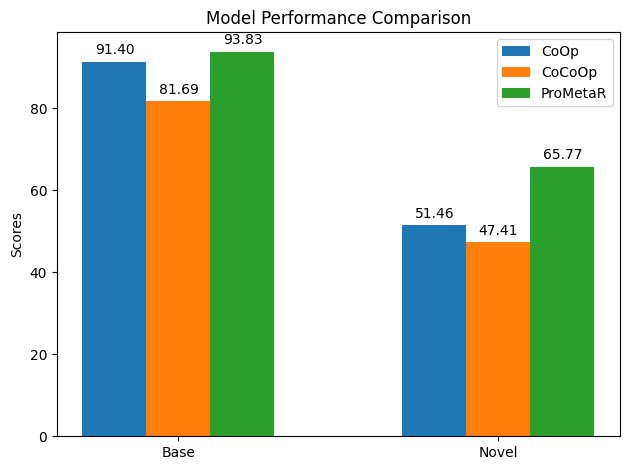

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 메트릭 데이터
metrics = ['Base', 'Novel']

coop_acc_list = [coop_base_acc, coop_novel_acc]
cocoop_acc_list = [cocoop_base_acc, cocoop_novel_acc]
prometar_acc_list = [prometar_base_acc, prometar_novel_acc]


# 막대 너비
bar_width = 0.2

# X축 위치 설정
index = np.arange(2)

# bar plot 생성
fig, ax = plt.subplots()

bar1 = ax.bar(index, coop_acc_list, bar_width, label='CoOp')
bar2 = ax.bar(index + bar_width, cocoop_acc_list, bar_width, label='CoCoOp')
bar3 = ax.bar(index + bar_width*2, prometar_acc_list, bar_width, label='ProMetaR')


# 제목과 레이블 설정
ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks(index + bar_width )
ax.set_xticklabels(metrics)
ax.legend()

# 막대에 값 표시
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 2 points vertical offset
                    textcoords='offset points',
                    ha='center', va='bottom')

add_value_labels(bar1)
add_value_labels(bar2)
add_value_labels(bar3)


# 그래프 출력
plt.tight_layout()
plt.show()
